# 一、套件引入

In [1]:
import io
import os
import sys
import time
import torch
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
sys.dont_write_bytecode = True
warnings.filterwarnings("ignore")
device = "cuda"

class MyDataSet(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx]
        return x

# 二、模型架構設計

## 1. 子模塊設計

### (1) Local Frequency Module

In [2]:
class attention(nn.Module):
    def __init__(self, n_dim):
        super(attention, self).__init__()
        self.k_w = nn.Linear(n_dim, n_dim)
        self.q_w = nn.Linear(n_dim, n_dim)
        self.v_w = nn.Linear(n_dim, n_dim)
        self.scale = n_dim**(-.5)
    def forward(self, x):
        x = x.permute(0, 2, 1) #x:(N, W, 1) -> (N, 1, W)
        k = self.k_w(x) #k: (N, 1, W)
        q = self.q_w(x) #q: (N, 1, W)
        v = self.v_w(x) #v: (N, 1, W)
        weight = torch.softmax(torch.matmul(k.permute(0, 2, 1), q)*(self.scale), dim = 1) #k.permute(0, 2, 1):(N, W, 1), q:(N, 1, W) -> (N, W, W)
        out = torch.matmul(v, weight)
        return out
    
class LFM(nn.Module):
    def __init__(self, n_dim, n_hid1, n_hid2, n_seq):
        super(LFM, self).__init__()
        self.dense = nn.Linear(n_seq, n_hid1)
        self.attn = attention(n_hid1)
        self.ffd = nn.Linear((n_dim - n_seq + 1)*n_hid1, n_hid2)

        # parameters setup
        self.n_dim, self.n_seq, self.n_hid1, self.n_hid2 = n_dim, n_seq, n_hid1, n_hid2

    def forward(self, x):
        out = x.unfold(1, self.n_seq, 1) # (N, W) -> (N, n, k)
        out = self.hamming_window(out)
        out = torch.fft.fft(out).real # (N, n, k)
        out = self.dense(out).reshape(out.shape[0], self.n_hid1, -1) # (N, n, k) -> (N, n, l) -> (N, l, n)
        out = self.attn(out).reshape(out.shape[0], -1) # (N, l, n) -> (N, l, n) -> (N, n*l)
        out = nn.ReLU()(self.ffd(out)) # (N, n*l) -> (N, d)
        return out

    @staticmethod
    def hamming_window(arr):
        n_batch, n_wins, n_seq = arr.shape
        hamming_win = 0.54 - 0.46 * torch.cos(2 * torch.pi * torch.arange(n_seq) / (n_seq - 1))
        hamming_win = hamming_win.reshape(1, 1, -1)
        res = arr * hamming_win.to(device)
        return res

### (2) Global Frequency Module

In [3]:
class GFM(nn.Module):
    def __init__(self, n_dim, n_hid):
        super(GFM, self).__init__()
        self.dense = nn.Linear(n_dim, n_hid)

    def forward(self, x):
        x = self.hamming_window(x)
        out = torch.fft.fft(x).real
        out = nn.ReLU()(self.dense(out))
        out = nn.Dropout(p = .1)(out)
        return out
    
    @staticmethod
    def hamming_window(arr):
        N = arr.shape[1]
        hamming_win = 0.54 - 0.46 * torch.cos(2 * torch.pi * torch.arange(N) / (N - 1))
        res = arr * hamming_win.to(device)
        return res

### (3) VAE

In [4]:
class VAE(nn.Module):
    def __init__(self, n_hid2, n_dim):
        n_hid = n_hid2*2 + n_dim
        super(VAE, self).__init__()
        # Encoder
        self.Encoder = nn.Sequential(
            nn.Linear(n_hid, n_hid//2),
            nn.ReLU(),
            nn.Linear(n_hid//2, n_hid//4),
            nn.ReLU()
        )
        # Variational Inference
        self.mean = nn.Linear(n_hid//4, n_hid//8)
        self.logvar = nn.Linear(n_hid//4, n_hid//8)

        # Decoder
        self.Decoder = nn.Sequential(
            nn.Linear(n_hid//8 + n_hid2*2, n_hid//4),
            nn.ReLU(),
            nn.Linear(n_hid//4, n_hid//2),
            nn.ReLU(),
        )

        # Variational Inference
        self.recon_mean = nn.Linear(n_hid//2, n_dim)
        self.recon_logvar = nn.Linear(n_hid//2, n_dim)

    def forward(self, x, LF, GF):
        # Encoder
        out = self.Encoder(x)
        
        # Variational Inference
        z_mean = self.mean(out)
        z_logvar = self.logvar(out)
        std = torch.exp(0.5*z_logvar)
        z = torch.randn_like(std)*std + z_mean

        # Decoder
        z = torch.cat((z, LF, GF), dim = 1)
        out = self.Decoder(z)

        # Variational Inference
        mean = self.recon_mean(out)
        logvar = self.recon_logvar(out)
        return mean, logvar

    def fit(self, x, LF, GF):
        # Encoder
        out = self.Encoder(x)
        
        # Variational Inference
        z_mean = self.mean(out)
        z_logvar = self.logvar(out)
        std = torch.exp(0.5*z_logvar)
        z = torch.randn_like(std)*std + z_mean

        # Decoder
        z = torch.cat((z, LF, GF), dim = 1)
        out = self.Decoder(z)

        # Variational Inference
        mean = self.recon_mean(out)
        logvar = self.recon_logvar(out)
        return z_mean, z_logvar, mean, logvar

### (4) Siamese Discriminator

In [5]:
class sub_network(nn.Module):
    def __init__(self, n_dim, n_hid):
        super(sub_network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = n_dim, out_channels = n_hid, kernel_size = 3, padding = 1)
        self.maxp1 = nn.MaxPool1d(kernel_size = 3, stride = 1)

        self.conv2 = nn.Conv1d(in_channels = n_hid-3+1, out_channels = n_hid//2, kernel_size = 3, padding = 1)
        self.maxp2 = nn.MaxPool1d(kernel_size = 3, stride = 1)
        self.fc = nn.Linear(n_hid//2-3+1, 32)
    def forward(self, x):
        x = x.unsqueeze(-1)
        n_batch, n_seq, n_feat = x.shape

        x = self.conv1(x)
        x = x.permute(0, 2, 1)
        x = self.maxp1(x)
        x = x.permute(0, 2, 1)


        x = self.conv2(x)
        x = x.permute(0, 2, 1)
        x = self.maxp2(x)
        x = x.permute(0, 2, 1)

        x = self.fc(x.squeeze(-1))
        return x
    
class Siamese_Discriminator(nn.Module):
    def __init__(self, n_dim, n_hid):
        super(Siamese_Discriminator, self).__init__()
        self.subnetwork1 = sub_network(n_dim, n_hid)
        self.subnetwork2 = sub_network(n_dim, n_hid)
    def forward(self, x1, x2):
        out1 = self.subnetwork1(x1)
        out2 = self.subnetwork2(x2)
        return torch.mean((out1 - out2)**2, dim = 1)

## 2. 主模型設計

In [6]:
class FCVAE(nn.Module):
    def __init__(self, n_dim, n_hid1, n_hid2, n_seq):
        super(FCVAE, self).__init__()
        self.n_dim, self.n_hid1, self.n_hid2, self.n_seq = n_dim, n_hid1, n_hid2, n_seq

        self.GFM = GFM(n_dim, n_hid2)
        self.LFM = LFM(n_dim, n_hid1, n_hid2, n_seq)
        self.VAE = VAE(n_hid2, n_dim)
        n_latent = n_hid2*2 + n_dim
    
    def forward(self, x):
        gf = self.GFM(x)
        lf = self.LFM(x)
        out = torch.cat((x, gf, lf), dim = 1)
        mean, logvar = self.VAE(out, gf, lf)
        return mean, logvar

    def fit(self, x):
        gf = self.GFM(x)
        lf = self.LFM(x)
        out = torch.cat((x, gf, lf), dim = 1)
        z_mean, z_logvar, mean, logvar = self.VAE.fit(out, gf, lf)
        return z_mean, z_logvar, mean, logvar

## 3. 資料標準化

In [7]:
class z_score(nn.Module):
    def __init__(self, x):
        super(z_score, self).__init__()
        x = torch.tensor(x, dtype = torch.float32)
        self.mean = float(torch.mean(x))
        self.std = float(torch.std(x))

    def forward(self, data):
        data = torch.tensor(data, dtype = torch.float32)
        out = (data - self.mean)/self.std
        return out
    
    def reform(self, data):
        out = data*self.std + self.mean
        return out

## 4. 資料擴增

In [8]:
def augment_data(data):
    data = data.unsqueeze(-1)
    
    # 比例調控
    noise_level = 2

    # 添加噪音
    noisy_data = data + noise_level * torch.randn_like(data)

    # 時間位移
    shift = np.random.randint(1, data.shape[1])
    shifted_data = torch.roll(data, shifts = shift, dims = 1)

    # 特徵置換
    permuted_data = data.clone()
    idx = torch.randperm(data.shape[1])
    permuted_data[:, idx] = data[:, :]

    # 躺平特徵
    mus = torch.mean(data, dim = 1)
    horizontal_data = torch.zeros(size = data.shape).to(mus.device)
    horizontal_data[:, :, 0] += mus.reshape(-1, 1)

    # 合併擴增資料
    augmented_data = torch.cat([noisy_data, shifted_data, permuted_data, horizontal_data], dim = 0)
    augmented_data = augmented_data[torch.randperm(augmented_data.shape[0])[:data.shape[0]]]
    
    return augmented_data.squeeze(-1)

# 三、損失函數設計

In [9]:
def log_likelihood(mean, variance, target):
    import numpy as np
    """
    :param mean: The prediction mean value
    :param variance: The prediction variance
    :param target: The ground truth
    :return: The log likelihood value
    """
    LL = -.5*torch.log(2*np.pi*variance) - (target - mean)**2/(variance)
    LL = -torch.clamp(-LL, min = 0)
    LL = torch.sum(LL, dim = 1)
    return torch.mean(LL)

def kl_divergence(z_mean, z_logvar):
    """
    Compute the KL-Divergence of latent space w.r.t N(0, 1)
    
    
    :param z_mean: Mean of Latent, (n_batch, n_zdim)
    :param z_logvar: Log variance of Latent, (n_batch, n_zdim)
    :return: A single value of KL-Divergence in torch.tensor
    """
    kl = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), dim=-1)
    return kl.mean()  # 對 batch 求平均

def criterion(mean, logvar, z_mean, z_logvar, x, beta=.5):
    """
    Compute the reconstruct error via negative log_likelihood and KL-Divergence for VAE
    
    :param mean: The decoder for mean of the reconstruction
    :param logvar: The decoder for log_variance of the reconstruction
    :param z_mean: The mean of latent
    :param z_logvar: The log_variance of latent
    :param x: Raw data
    :param beta: The weight of KL_Divergence
    :return: The single value of total loss of the model
    """
    # Recons-Loss
    recon_loss = -log_likelihood(mean, logvar.exp(), x).mean()
    
    # KLDiv-Loss
    kl_div = kl_divergence(z_mean, z_logvar)
    
    # Total_Loss
    loss = recon_loss + beta * kl_div
    return loss

# 四、模型訓練

In [10]:
# 設定超參數
n_dim = 256
n_hid1 = 256
n_hid2 = 128
n_seq = 64

# 資料讀取
def create(abnormal = False):
    data = list()
    
    if not abnormal:
        for i in range(20):
            temp = np.sin(np.linspace(0, 2*np.pi, np.random.randint(100, 200)))
            temp += np.random.normal(0, .1, size = temp.shape)
            data += temp.tolist()
    else:
        for i in range(20):
            if i < 10 or i > 15:
                temp = np.sin(np.linspace(0, 2*np.pi, np.random.randint(100, 200)))
                temp += np.random.normal(0, .1, size = temp.shape)
                data += temp.tolist()
            else:
                temp = np.sin(np.linspace(0, 2*np.pi, np.random.randint(20, 90)))
                temp += np.random.normal(0, .1, size = temp.shape)
                data += temp.tolist()
    return torch.tensor(data, dtype = torch.float32)

arr = create(False)
wins = arr.unfold(0, n_dim, 1)
tr = wins[:wins.shape[0]//2]
val = wins[wins.shape[0]//2:]

ts_arr = create(True)
ts = ts_arr.unfold(0, n_dim, 1)

# 資料前處理
z_scorer = z_score(tr)
tr = z_scorer(tr).to(device)
val = z_scorer(val).to(device)
ts = z_scorer(ts).to(device)

In [11]:
model = FCVAE(n_dim, n_hid1, n_hid2, n_seq).to(device)
critor = Siamese_Discriminator(n_dim, (n_hid2*2 + n_dim)//8).to(device)
g_optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-2)
d_optimizer = optim.AdamW(critor.parameters(), lr = 1e-4, weight_decay = 1e-2)
dataloader = DataLoader(MyDataSet(tr), batch_size = 1024, shuffle = True)
History = list()

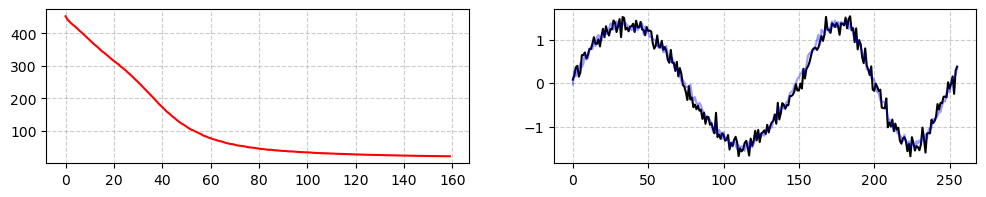

In [12]:
epochs = 800
for epoch in range(1, epochs + 1):
    try:
        print("[Epoch {}]".format(epoch))
        loss_val = .0
        for batch in dataloader:
            batch_hat, _ = model(batch)
            d_loss = 0.5 - critor(batch_hat, batch)
            d_loss *= d_loss > 0
            d_loss = torch.mean(d_loss)
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            if epoch%5 == 0:

                # FCVAE重構訓練
                z_mean, z_logvar, mean, logvar = model.fit(batch)
                loss = .45*criterion(mean, logvar, z_mean, z_logvar, batch)

                # 擴增資料 KL 訓練
                z_mean_aug, z_logvar_aug, _, _ = model.fit(augment_data(batch))
                loss += .1*kl_divergence(z_mean_aug, z_logvar_aug)

                # 混淆判別器 Loss
                batch_hat, batch_logvar = model(batch)
                loss += .45*critor(batch_hat, batch).mean()

                # 更新
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
                loss_val += loss.item()

        if epoch%5 == 0:
            History += [loss_val]
            clear_output()
            fig, ax = plt.subplots(1, 2, figsize = (12, 2))
            ax[0].plot(History, color = "red")
            ax[0].grid(color = 'gray', linestyle = "--", alpha = .4)
            ax[1].plot(batch.tolist()[0], color = "black")
            ax[1].plot(batch_hat.tolist()[0], color = "blue", alpha = .4)
            ax[1].grid(color = 'gray', linestyle = "--", alpha = .4)
            plt.show()

    except KeyboardInterrupt:
        clear_output()
        fig, ax = plt.subplots(1, 2, figsize = (12, 2))
        ax[0].plot(History, color = "red")
        ax[0].grid(color = 'gray', linestyle = "--", alpha = .4)
        ax[1].plot(batch.tolist()[0], color = "black")
        ax[1].plot(batch_hat.tolist()[0], color = "blue", alpha = .4)
        ax[1].grid(color = 'gray', linestyle = "--", alpha = .4)
        plt.show()
        break


# 五、計算偵測損失

In [13]:
model.eval()
clear_output()

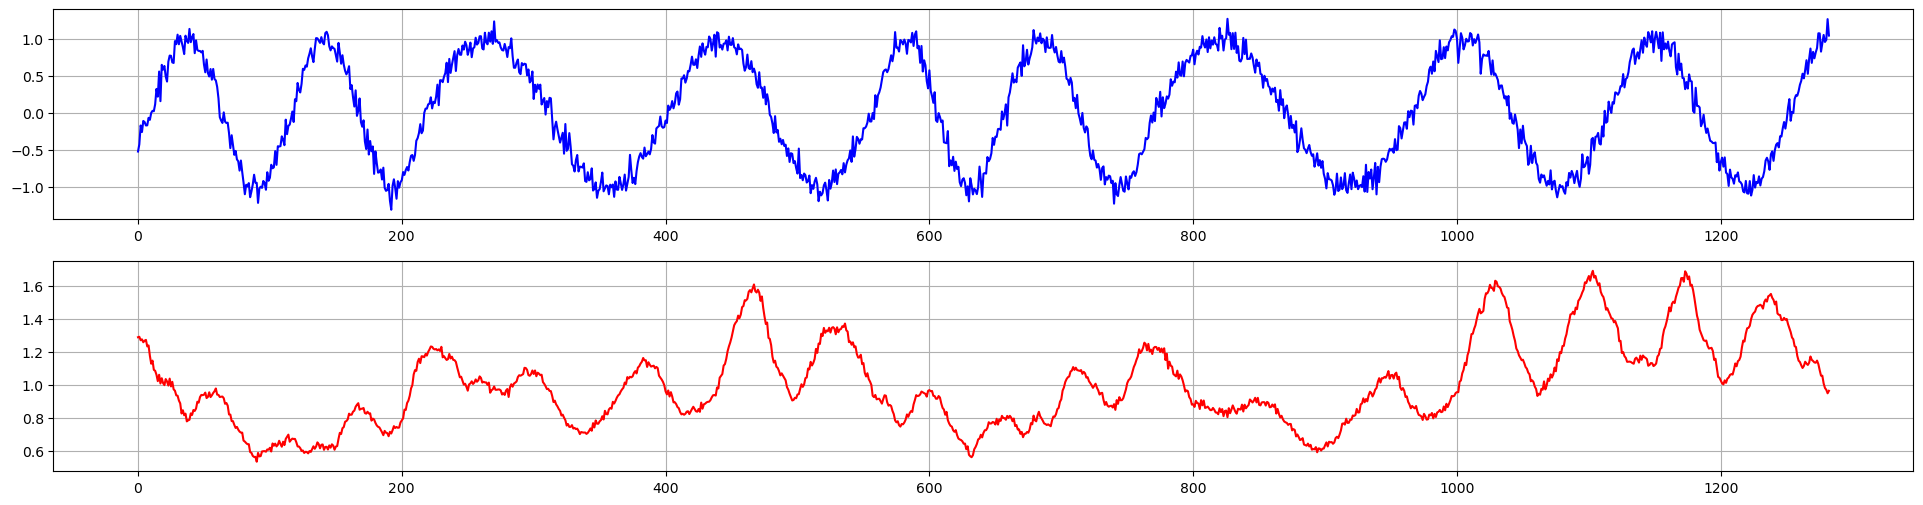

In [14]:
inference = DataLoader(MyDataSet(tr), batch_size = 1024)
score = list()
for batch in inference:
    pred, _ = model(batch)
    score += critor(pred, batch).tolist()

fig, ax = plt.subplots(2, 1, figsize = (24, 6))
ax[0].plot(arr[n_dim//2:-n_dim//2][:len(score)], color = "blue")
ax[0].grid()
ax[1].plot(score, color = "red")
ax[1].grid()
plt.show()
tmp_pt = len(score)

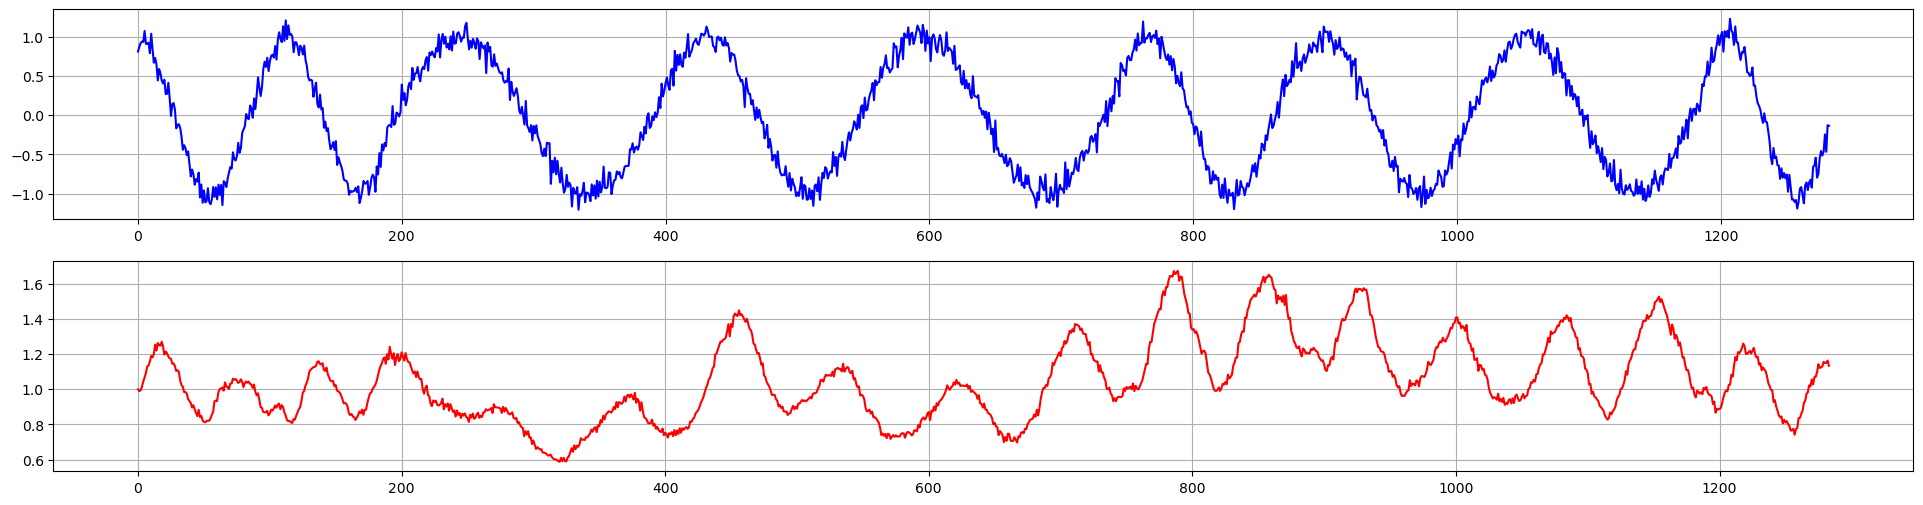

In [15]:
inference = DataLoader(MyDataSet(val), batch_size = 1024)
score = list()
for batch in inference:
    pred, _ = model(batch)
    score += critor(pred, batch).tolist()

fig, ax = plt.subplots(2, 1, figsize = (24, 6))
ax[0].plot(arr[n_dim//2:-n_dim//2][tmp_pt:tmp_pt+len(score)], color = "blue")
ax[0].grid()
ax[1].plot(score, color = "red")
ax[1].grid()
plt.show()

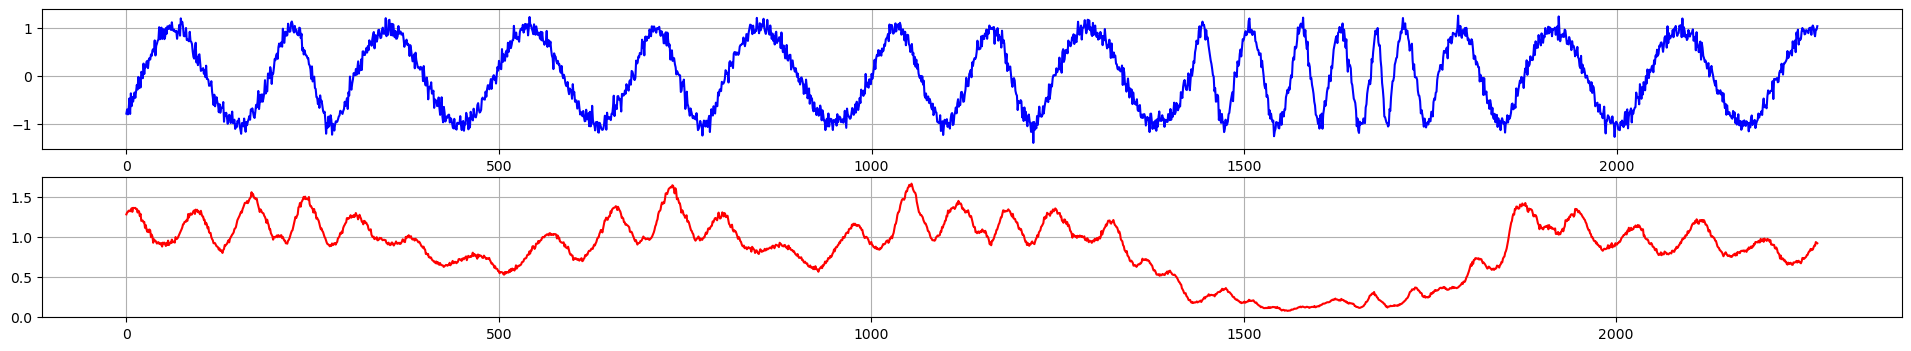

In [16]:
inference = DataLoader(MyDataSet(ts), batch_size = 1024)
score = list()
for batch in inference:
    pred, _ = model(batch)
    score += critor(pred, batch).tolist()

fig, ax = plt.subplots(2, 1, figsize = (24, 4))
ax[0].plot(ts_arr[n_dim//2:-n_dim//2], color = "blue")
ax[0].grid()
ax[1].plot(score, color = "red")
ax[1].grid()
plt.show()